In [1]:
sys.path.append('/mlodata1/lugeon/eeg_project/scripts')
from training.representation import models

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models.AdverserialAutoencoder

training.representation.models.adverserial.AdverserialAutoencoder

In [1]:
import pandas as pd
import numpy as np
import h5py
import sys 
import glob

import matplotlib.pyplot as plt
import scipy.io as sio
from torch.utils.data import DataLoader
import torch

sys.path.append('/home/lugeon/eeg_project/scripts')
sys.path.append('/mlodata1/lugeon/eeg_project/scripts')

from training.dataset.datasets import EEG_Image_Batch_Dataset
from training.representation import models, losses

/mlodata1/lugeon/miniconda3/envs/eeg-dream-conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'AdverserialAutoencoder' from 'training.representation.models.adverserial' (/mlodata1/lugeon/eeg_project/scripts/training/representation/models/adverserial.py)

In [2]:
def change_val(d):
    for k, v in d.items():
        if isinstance(v, dict):
            change_val(v)
        else:
            if k == 'weight':
                d[k] = v + 1


myd = {'r': 2, 'weight': 0, 'r2': {'weight': 10}}
change_val(myd)

In [3]:
myd

{'r': 2, 'weight': 1, 'r2': {'weight': 11}}

In [19]:
dataset = EEG_Image_Batch_Dataset(
    hdf5_file='/mlodata1/lugeon/dream_data/processed/madison_20sec/dataset_nrem_binary.h5',
    window=10,
    slide=5,
    shuffle=True,
    batch_size=None,
    transforms=None,
    return_metadata=True,
    output_type='label',
    next_frame_index=None,
    exclude_subject=[0, 1])

loader = DataLoader(dataset, batch_size=None, shuffle=False)

In [20]:
loader = DataLoader(dataset, batch_size=None, shuffle=False)

labels = []
subject_ids = []
trial_ids = []
frame_ids = []
sleep_stages = []
elapsed_times = []

for input_batch, output_batch, metadata in loader:
    
    sid_batch, tid_batch, fid_batch, ss_batch, et_batch = metadata
                        
    labels.append(output_batch.cpu().detach().numpy())
    subject_ids.append(sid_batch.cpu().detach().numpy())
    trial_ids.append(tid_batch.cpu().detach().numpy())
    frame_ids.append(fid_batch.cpu().detach().numpy())
    sleep_stages.append(ss_batch.cpu().detach().numpy())
    elapsed_times.append(et_batch.cpu().detach().numpy())
    
    del input_batch
    del output_batch
    del sid_batch
    del ss_batch
        
y = np.concatenate(labels)
s = np.concatenate(subject_ids)
t = np.concatenate(trial_ids)
f = np.concatenate(frame_ids)
ss = np.concatenate(sleep_stages)
et = np.concatenate(elapsed_times)

In [21]:
pd.Series(s).value_counts().sort_index()

2    276
3    228
4    198
5    282
6    348
dtype: int64

In [2]:
with np.load('/mlodata1/lugeon/dream_data/processed/healthy/images/H009.npz') as images:
    for k in images:
        print(k)

H009_E1_NREM_S03.img
H009_E1_NREM_S05.img
H009_E1_NREM_S06.img
H009_E1_NREM_S07.img
H009_E1_NREM_S09.img
H009_E1_REM_S04.img
H009_E1_REM_S08.img
H009_E1_REM_S12.img
H009_E2_NREM_S01.img
H009_E2_NREM_S07.img
H009_E2_NREM_S08.img
H009_E2_NREM_S09.img
H009_E1_NREM_S01.img
H009_E1_NREM_S02.img


In [4]:
with np.load('/home/lugeon/eeg_project/H009.npz') as images:
    h018 = images['H009_E1_REM_S12.img']

h018.shape

(237, 5, 32, 32)

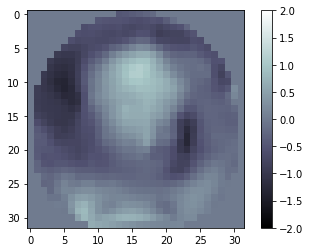

In [5]:
fig, ax = plt.subplots()
shw = ax.imshow(h018[3, 4, :, :], cmap='bone', vmin=-2, vmax=2);
bar = plt.colorbar(shw)

In [ ]:
fig, ax = plt.subplots()
shw = ax.imshow(h018[0, 1, :, :], cmap='bone', vmin=-2, vmax=2);
bar = plt.colorbar(shw)

In [ ]:
with h5py.File('/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/hdf5/32_32_FFT_data_all_bands_120s_20sbj_log_z-score_stages23') as f:
    for k in f:
        print(f[k])

In [4]:
with h5py.File('/mlodata1/lugeon/dream_data/processed/baseline/dataset_bis.h5') as f:
    for k in f:
        print(f[k])

    frame_id = f['frame_id'][:]
    subject_id = f['subject_id'][:]
    trial_id = f['trial_id'][:]
    images = f['images'][:]
    labels = f['labels'][:]
    sleep_cycle = f['sleep_cycle'][:]

<HDF5 dataset "frame_id": shape (46176,), type "<f4">
<HDF5 dataset "images": shape (46176, 5, 32, 32), type "<f4">
<HDF5 dataset "labels": shape (46176,), type "<f4">
<HDF5 dataset "sleep_cycle": shape (46176,), type "<f4">
<HDF5 dataset "sleep_stage": shape (46176,), type "<f4">
<HDF5 dataset "subject_id": shape (46176,), type "<f4">
<HDF5 dataset "subject_name": shape (1,), type "|S4">
<HDF5 dataset "trial_id": shape (46176,), type "<f4">


In [8]:
pd.DataFrame(sleep_cycle).value_counts()

2.0    14814
3.0    10614
4.0    10494
1.0    10254
dtype: int64

In [12]:
with h5py.File('/mlodata1/lugeon/dream_data/processed/healthy/dataset_small.h5') as f:

    df = pd.DataFrame({
                'sid': f['subject_id'][:], 
                'tid': f['trial_id'][:], 
                'fid': f['frame_id'][:],
                'ss': f['sleep_stage'][:]
                })

In [34]:
file_path = '/mlodata1/lugeon/dream_data/chuv/healthy/H009/H009_E1_NREM_S01.mat'
with h5py.File(file_path,'r') as file:
        for k in file:
                print(k)
        time_signal = np.array(file['subject'])

#refs#
chanlocs
condi
datavr
events
numseg
ordseg
reactime
srate
stage
subject


In [2]:
torch.manual_seed(0)

ft = models.FineTuner(
    result_dir='/home/lugeon/eeg_project/results/transformers/masked_auto_encoder_mask9',
    encoding_dim=512,
    n_classes=2,
    dropout=0.8,
    adverserial=True,
    adv_strength=0.0,
    n_adv_classes=7,
    freeze=False)

optim = torch.optim.Adam(ft.parameters(), lr = 1)
out = ft.forward(torch.ones(7, 10, 5, 32, 32))
loss = (out[0] - (torch.ones(7, 2) * 1000)).sum()
loss.backward()
optim.step()

w = ft.model.encoder[0][0].fn[0].weight
w[:10]

tensor([0.0341, 2.0136, 0.0437, 2.0085, 0.0713, 2.0199, 0.0541, 2.0203, 2.0593,
        2.0386], grad_fn=<SliceBackward0>)

In [7]:
def set_dropout(model, new_drop_rate):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = new_drop_rate
        set_dropout(child, new_drop_rate)
        
set_dropout(ft, new_drop_rate=0.2)

In [8]:
ft

FineTuner(
  (model): MaskedAutoEncoder(
    (encoder): AttentionNet(
      (0): AttentionBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (qkv): Linear(in_features=512, out_features=1536, bias=True)
              (att_drop): Dropout(p=0.2, inplace=False)
              (projection): Linear(in_features=512, out_features=512, bias=True)
            )
            (2): Dropout(p=0.2, inplace=False)
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): Linear(in_features=512, out_features=2048, bias=True)
              (1): GELU()
              (2): Dropout(p=0.2, inplace=False)
              (3): Linear(in_features=2048, out_features=512, bias=True)
            )
            (2): Dropout(p=0.2, inplace=False)
    

In [71]:
ch1 = '/home/lugeon/eeg_project/scripts/training/representation/result/arch_comparison/next_frame_baseline/checkpoint.pt'
ch2 = '/home/lugeon/eeg_project/scripts/training/representation/result/evaluate/baseline/0/checkpoint.pt'

In [72]:
torch.load(ch1)['encoder.1.weight']

tensor([[-3.3087e-05,  2.3708e-03, -3.6374e-03,  ..., -4.2212e-03,
         -4.2731e-03,  1.7014e-03],
        [ 2.8183e-03,  3.3636e-03,  5.4030e-04,  ...,  3.8198e-03,
         -2.3750e-03,  4.1322e-03],
        [-1.2480e-03,  3.3899e-03, -3.1663e-03,  ...,  1.5401e-03,
          2.5765e-03, -1.7713e-03],
        ...,
        [-3.4439e-03, -1.7843e-03,  1.3494e-03,  ..., -1.3713e-03,
         -9.1726e-04, -5.6303e-04],
        [-1.6230e-04,  4.2410e-03, -3.6021e-03,  ..., -2.1716e-03,
         -3.3971e-03, -1.1198e-03],
        [-2.7684e-03, -2.7571e-03, -3.2507e-03,  ...,  3.0038e-03,
          2.3743e-03,  4.2741e-03]], device='cuda:0')

In [74]:
torch.load(ch2)['model.encoder.1.weight']

tensor([[-3.3087e-05,  2.3708e-03, -3.6374e-03,  ..., -4.2212e-03,
         -4.2731e-03,  1.7014e-03],
        [ 2.8183e-03,  3.3636e-03,  5.4030e-04,  ...,  3.8198e-03,
         -2.3750e-03,  4.1322e-03],
        [-1.2480e-03,  3.3899e-03, -3.1663e-03,  ...,  1.5401e-03,
          2.5765e-03, -1.7713e-03],
        ...,
        [-3.4439e-03, -1.7843e-03,  1.3494e-03,  ..., -1.3713e-03,
         -9.1726e-04, -5.6303e-04],
        [-1.6230e-04,  4.2410e-03, -3.6021e-03,  ..., -2.1716e-03,
         -3.3971e-03, -1.1198e-03],
        [-2.7684e-03, -2.7571e-03, -3.2507e-03,  ...,  3.0038e-03,
          2.3743e-03,  4.2741e-03]], device='cuda:0')